<a href="https://www.kaggle.com/code/tomababi/suicide-rates-overview-1985-to-2021?scriptVersionId=117407269" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('/kaggle/input/suicide-rates-overview-1985-to-2021/master.csv')

We begin by doing some exploratory analysis.

In [2]:
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31756 entries, 0 to 31755
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             31756 non-null  object 
 1   year                31756 non-null  int64  
 2   sex                 31756 non-null  object 
 3   age                 31756 non-null  object 
 4   suicides_no         30556 non-null  float64
 5   population          31756 non-null  int64  
 6   suicides/100k pop   31756 non-null  float64
 7   country-year        31756 non-null  object 
 8   HDI for year        12300 non-null  float64
 9    gdp_for_year ($)   31756 non-null  object 
 10  gdp_per_capita ($)  31756 non-null  float64
 11  generation          31756 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 2.9+ MB


,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,31756.000000,30556.000000,3.175600e+04,31756.000000,12300.000000,31756.000000
mean,2003.395390,237.136242,7.217454e+06,11.716668,0.793666,17588.954606
std,9.760604,867.956107,5.799323e+07,21.590926,0.097480,19464.861140
min,1985.000000,0.000000,2.780000e+02,0.000000,0.377790,251.000000
25%,1996.000000,3.000000,1.288210e+05,0.370000,0.727000,3765.000000
50%,2004.000000,25.000000,5.468325e+05,4.285000,0.800457,10062.000000
75%,2011.000000,132.000000,2.908763e+06,14.560000,0.874000,25622.000000
max,2020.000000,22338.000000,1.411100e+09,515.092734,0.975114,126352.000000


We see there are some missing values. Also some columns need to be transformed to appropriate type (gdp_for_year to float for example). Population column is apparently the number of people of specific age group and not the country populaion. Country column is useless, we already have country and year column, so we can drop that one and we can also drop 'HDI for year' column since it has too many missing values.  


In [3]:
df.drop(['country-year', 'HDI for year'], axis = 1, inplace = True)

In [4]:
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', ' gdp_for_year ($) ', 'gdp_per_capita ($)',
       'generation'],
      dtype='object')

Let's rename the columns and change gdp_year to float. 

In [5]:
df.columns = ['country', 'year', 'sex', 'age', 'suicides', 'population', 'suicides/100k', 'gdp_year', 'gdp_capita', 'generation']
df['gdp_year'] = df.gdp_year.str.replace(',','').astype('float')

Drop the rows where there are no suicides. 

In [6]:
df = df[df['suicides/100k'] != 0]

Let's check if there are any differences between ages and sex groups for number of suicides. First we reorder age categories so we'll have an easier time intepreting data visualization. 

In [7]:
df.age = df.age.astype('category').cat.set_categories(['5-14 years', '15-24 years', '25-34 years', '35-54 years', '55-74 years', '75+ years'], ordered = True)

<AxesSubplot:xlabel='age', ylabel='suicides/100k'>

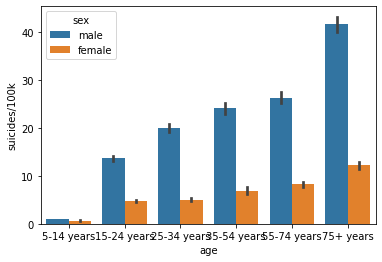

In [8]:
sns.barplot(x = 'age', y = 'suicides/100k', hue = 'sex', data = df)

The difference is quite big. If you're a man you're more likely to commit suicide and the older you are, the higher likelihood of commiting suicide. 

Let's check for the differences in gdp_capita.

<AxesSubplot:xlabel='gdp_capita', ylabel='suicides/100k'>

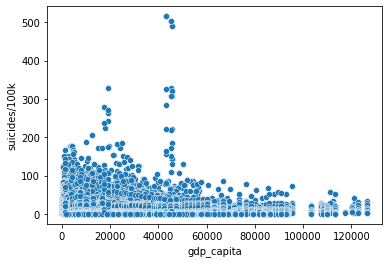

In [9]:
sns.scatterplot(x = 'gdp_capita', y ='suicides/100k' , data = df)

The trend seems to show that the higher gdp_capita, the less suicides the country has. Now let's take a look at individual countries. 

<AxesSubplot:xlabel='suicides/100k', ylabel='country'>

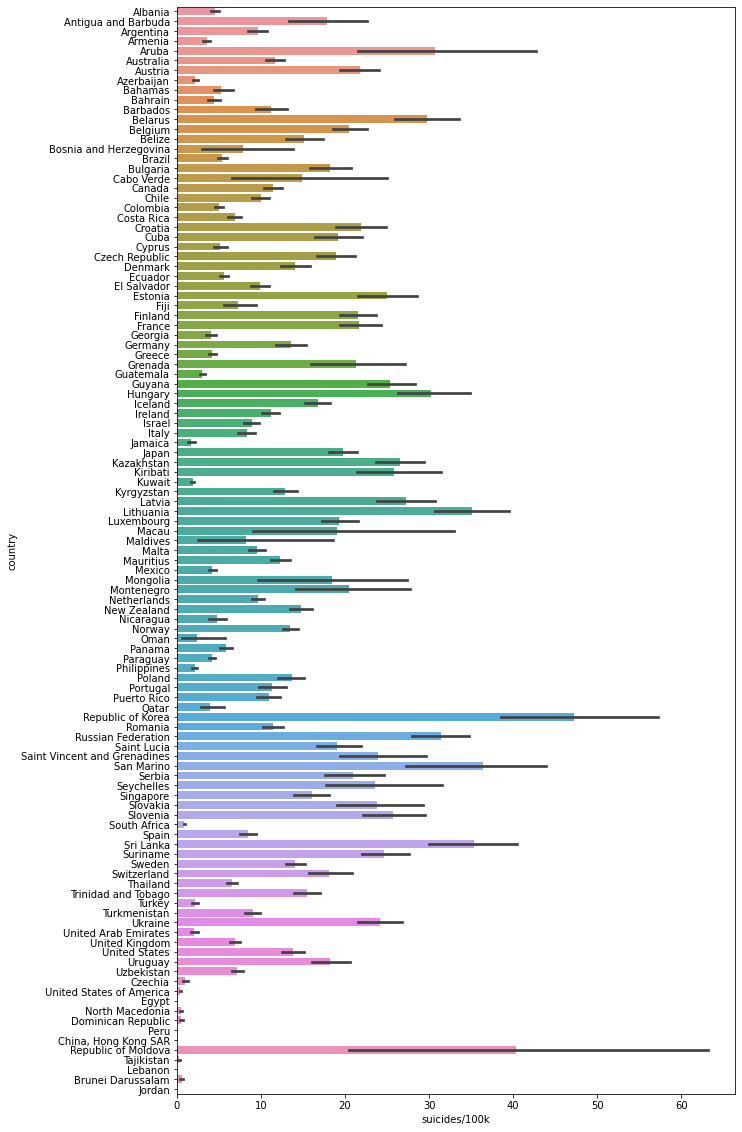

In [10]:

plt.figure(figsize = (10,20))
sns.barplot(x = 'suicides/100k', y = 'country', data = df)

Let's look at suicides over the years and if they affect gender differently. 

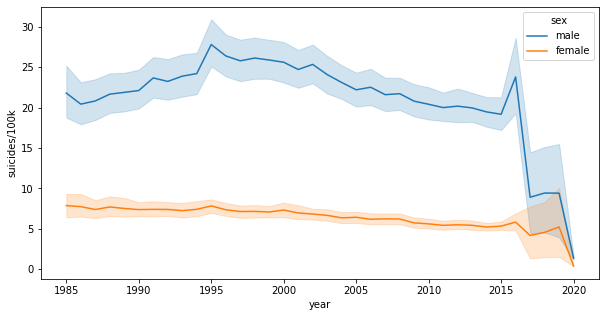

In [11]:
plt.figure(figsize = (10,5))

ax = sns.lineplot(x = 'year', y = 'suicides/100k', hue = 'sex',  data = df)



It appears that there have been fewer suicides over the last decade. The number of men commiting suicide is almost three times larger than the number of women commiting suicide. This could be correlated to the increasing GDP per capita. Let's take a look at this relationship. 

<AxesSubplot:xlabel='year', ylabel='suicides/100k'>

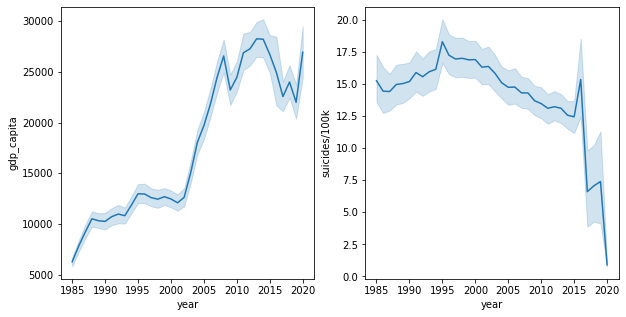

In [12]:

fig, axes = plt.subplots(1,2 ,figsize=(10, 5))

sns.lineplot(x = 'year', y = 'gdp_capita', data = df, ax = axes[0])
sns.lineplot(x = 'year', y = 'suicides/100k', data = df, ax = axes[1])

We see as GDP increases, the number of suicides drop. We even a see a little drop in gdp around year 2015 followed by an increase of suicides at the sime time. 

Now we'll have a look and try to build a machine learning model to see if we can predict the number of suicides/100k. I'll choose a random forest regressor model. Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap and Aggregation, commonly known as bagging. The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees. 

We will need to transform the data so it will be ready for analysis.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector

In [14]:
df.age = df.age.astype('object')
X = df.drop('suicides/100k', axis = 1)
y = df['suicides/100k']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [15]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')

We'll take a look to see which max_depth is the most appropriate for our regressor. 

In [16]:
results = {}

for i in range(1,20):
    
    clf = RandomForestRegressor(random_state=42, max_depth = i)

    pipeline = Pipeline([('prep',column_trans),
                         ('clf', clf)])
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    results[i] = score

In [17]:
results


{1: 0.21505427589982073,
 2: 0.3613133655410421,
 3: 0.44070088116832307,
 4: 0.5263429092014651,
 5: 0.6433234104914238,
 6: 0.7429389160308946,
 7: 0.8217898234431218,
 8: 0.8868421535523866,
 9: 0.930924043790885,
 10: 0.9548451729339427,
 11: 0.9667419950331255,
 12: 0.9735603573547759,
 13: 0.9759141918869922,
 14: 0.9775028631923423,
 15: 0.9776476198324437,
 16: 0.9777665879985415,
 17: 0.9786640263316785,
 18: 0.9778368591585909,
 19: 0.9789879462628616}

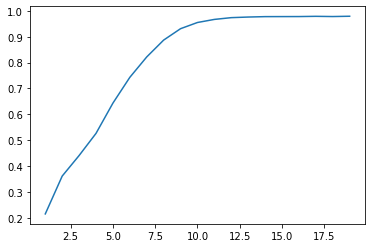

In [18]:
plt.plot(*zip(*sorted(results.items())))

We see that anything over 10 is overfitting and our model doesn't improve that much. We reach a score of 0.974 accuracy. Now we can look at the most important features for the model. 

In [19]:
clf = RandomForestRegressor(random_state=42, max_depth = 10)
pipeline = Pipeline([('prep',column_trans),
                         ('clf', clf)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa7eaafd8d0>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa7eaafda10>)])),
                ('clf', RandomForestRegressor(max_depth=10, random_state=42))])

In [20]:
pipeline['clf'].feature_importances_

array([0.02973166, 0.31910483, 0.23279347, 0.19054826, 0.00836323,
       0.00257311, 0.11722521, 0.09823325, 0.00142697])

Let's visualize it. 

<AxesSubplot:xlabel='IMPORTANCE', ylabel='FEATURE'>

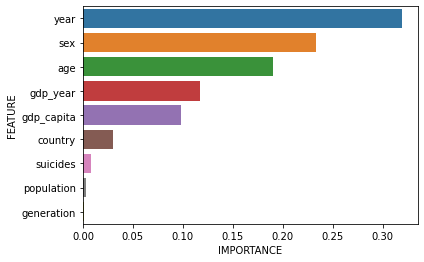

In [21]:
feature_list = []
targets = X.columns

#Print the name and gini importance of each feature

for feature in zip(targets, pipeline['clf'].feature_importances_):
    feature_list.append(feature)
 

df_imp = pd.DataFrame(feature_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()

sns.barplot(x = 'IMPORTANCE', y = 'FEATURE', data = df_imp)

The graph shows most important factors when deciding the suicide rates. There are many reasons why it's this way. We see before that the year feature gives us an insight into how gdp affects suicides over the year. Countries are becoming more and more developed and people have more access to basic goods. There are many other factors deciding why gender plays such a big role. For example, we know that men are more likely to supress their feelings and are on average more violent, leading them to opt for more violent solutions to their problems. With age comes loneliness, the older you are and if you don't have a family, the higher chance that the people you love will be out of your life by then. 